# DSPy - Advanced Prompt Engineering

1. Breakout Room #1:
  - Task 1: Dependencies
  - Task 2: Loading Our Model
  - Task 3: Loading Our Data
  - Task 4: Setting Our Signature
  - Task 5: Creating a Predictor
  - Task 6: Making a Chain, I mean...Module
  - Task 7: Evaluate
  - Task 8: Program Optimization
2. Breakout Room #2:
  - Task 1: Defining Appliation
  - Task 2: Hyper-Parameters and Data
  - Task 3: Signature And Module Creation
  - Task 4: Evaluating Our LongFormQA Module
  - Task 5: Adding Assertions

---

In the following notebook, we'll explore an introduction to DSPy and what it can do in just a few lines of code!

# 🤝 Breakout Room #1

## Task 1: Dependencies

We'll start by installing DSPy, `nltk` (for later) and including our OpenAI API key.

In [1]:
# !pip install -qU dspy-ai nltk

DSPy can leverage OpenAI's models under the hood, and still provide an advantage - in order to do so, however, we'll need to provide an OpenAI API Key!

In [3]:
import os
import getpass

os.environ['OPENAI_API_KEY'] = getpass.getpass('OpenAI API Key: ')


## Task 2: Loading Our Model

Now we can setup our OpenAI language model - which we'll use through the remaining cells in the notebook.
- [IMPORTANT](https://github.com/stanfordnlp/dspy/blob/main/examples/migration.ipynb): Load DSPy's llm clients ONLY by **dspy.LM**. 
- dspy.LM leverages **LiteLLM**.
- Ways of directly loading each vendor's clinets (Only for reference)
    - [OpenAI](https://github.com/stanfordnlp/dspy/blob/main/docs/api/language_model_clients/OpenAI.md)
    - [Mistral](https://github.com/stanfordnlp/dspy/blob/main/docs/api/language_model_clients/Mistral.md)

In [4]:
from dspy import LM
llm = LM(model='openai/gpt-3.5-turbo')

./dspy_cache/compiler
Initialized chat model: openai/gpt-3.5-turbo


Similar to other libraries, we can call the LLM directly with a string to get a response!

In [5]:
llm("What is the square root of pi?")

['The square root of pi is approximately 1.77245385091.']

### 🚀 __call__ method of dspy.OpenAI

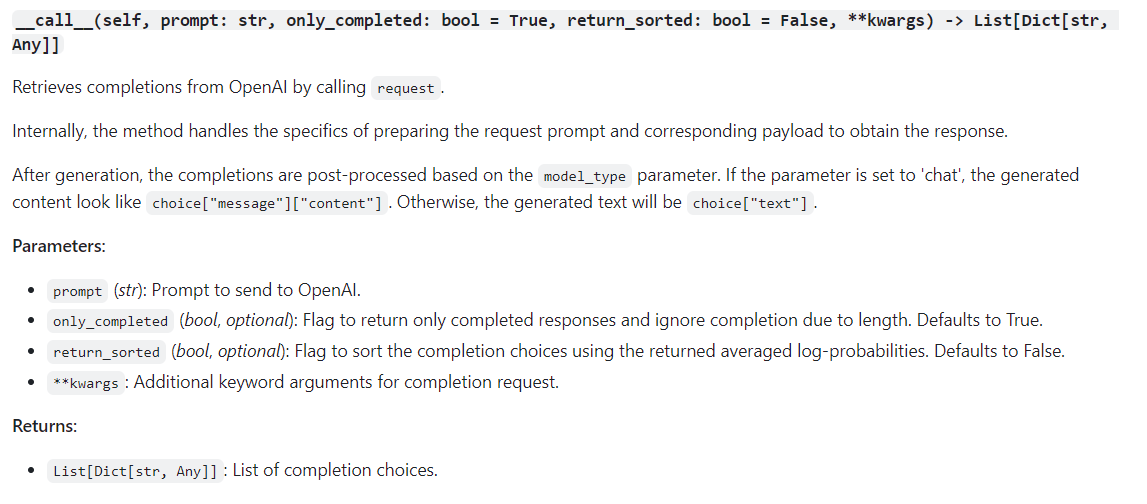

We'll also set our `setting.configure` with our OpenAI model in the `lm` (Language Model) field for a default LM to use in case we don't specify which LM we'd like to use when calling our DSPy `Predictors`.

### 🚀 dsp.utils.settings.Settings
- Once dspy is imported by 'import dspy', an object of dsp.utils.settings.Settings is instantiated by the reference of dspy.settings.
- Most importantly, it (dspy.settings) has 'config' attribute which is a Python dictionary contains **'default configurations'** when running DSPy's modules:
    - The default configurations can be overwrittdn by passing in any items at instantiation or at runtime (forward method).

In [6]:
import dspy   # 😉 At this momoment,  dspy.settings can be loaded.

dspy.settings.configure(lm=llm)   # 😉 configure() method allows override of any default configuration.

In [7]:
# 🚀 My own cell
for k, v in dspy.settings.items():
    print(f'{k}: {v}')

lm: <dspy.clients.lm.LM object at 0x7fbb0e79b8c0>
adapter: None
rm: None
branch_idx: 0
reranker: None
compiled_lm: None
force_reuse_cached_compilation: False
compiling: False
skip_logprobs: False
trace: []
release: 0
bypass_assert: False
bypass_suggest: False
assert_failures: 0
suggest_failures: 0
langchain_history: []
experimental: False
backoff_time: 10


## Task 3: Load Our Data

We're going to be using a dataset that provides a number of example sentences, along with a rating that indicates their "dopeness" level.

In [8]:
from datasets import load_dataset

dataset = load_dataset("llm-wizard/dope_or_nope_v2")

We have a total of 99 rows of data, and will be splitting that into a `trainset` and a `valset` - for training and evaluation.

In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Sentence', 'Rating', 'Fire Emojis'],
        num_rows: 99
    })
})

Due to the nature of the dataset, we'll need to shuffle our dataset to ensure our labels are not clumped up, and our `valset` is remotely representative to our `trainset`.

In [10]:
dataset = dataset.shuffle(seed=42)

We'll move our `Dataset` into the expected format in DSPy which is the [`Example`](https://dspy-docs.vercel.app/docs/deep-dive/data-handling/examples)!


Our examples will have two keys:

- `sentence`, our input sentence to be rated
- `rating`, our rating label

We'll specify our input as `sentence` to properly leverage the DSPy framework.

In [11]:
from dspy import Example  # 😉 Python's dictionary-like class with many additional features

trainset = []

for row in dataset["train"].select(range(0,len(dataset["train"])-10)):
  trainset.append(Example(sentence=row["Sentence"], rating=row["Rating"]).with_inputs("sentence"))

len(trainset)

89

We'll repeat the same process for our `valset` as well.

In [12]:
valset = []

for row in dataset["train"].select(range(len(trainset),len(dataset["train"]))):
  valset.append(Example(sentence=row["Sentence"], rating=row["Rating"]).with_inputs("sentence"))

len(valset)

10

Let's take a peek at an example from our `trainset` and `valset`!

In [13]:
train_example = trainset[0]
print(f"Sentence: {train_example.sentence}")
print(f"Label: {train_example.rating}")

Sentence: The results were satisfactory.
Label: 0


In [14]:
valset_example = valset[0]
print(f"Sentence: {valset_example.sentence}")
print(f"Label: {valset_example.rating}")

Sentence: This is top tier.
Label: 4


## Task 4: Setting Our Signature

The first foundational unit in DSPy is the `Signature`.

In a sense, a `Signature` can be thought of as both a prompt, as well as metadata about that prompt.

Going beyond just a simple `SystemMessage`, as seen in other frameworks, the `Signature` helps DSPy validate datatypes, create examples, and more.

> NOTE: DSPy's [documentation](https://dspy-docs.vercel.app/docs/deep-dive/signature/understanding-signatures#what-is-a-signature) goes into more detail about what exactly a `Signature` is.

In [15]:
# 🚀 An exception was raised on a later cell, so I tweaked this cell to resolve the issue.

from dspy import Signature, InputField, OutputField


class DopeOrNopeSignature(Signature):
  """Rate a sentence from 0 to 4 on a dopeness scale"""
  sentence: str = InputField()
  rating: int = OutputField()   # 😉 type is 'int' not 'str'

## Task 5: Creating a Predictor

Now that we have our `Signature`, we can build a `Predictor` that leverages it.

A `Predictor`, in the simplest terms, is what calls the LLM using our signature. Importantly, the `Predictor` knows how to leverage our signature to call the LLM. From DSPy's documentation, one of the most interesting parts of a `Predictor` is that it can *learn* to become better at the desired task!

Let's take a look at our `TypedPredictor` below to see more.

### 🚀 Typed modules
- When defining a Signature, the types of InputField() or OutputField() are by default **str**.
- Normal modules (e.f., Prodict, ChainOfThought, etc. ) does NOT enforce the type constraints specified in Signature
- TypedModules DO enforce the type contraints.
- Until now, at current version of DSPy, two Typed modules are available:
    - TypedPredictor : Typed conterpart to dspy.Predict
    - TypedChainOfThought : Typed conterpart to dspy.ChainOfThought   

In [16]:
from dspy.functional import TypedPredictor

generate_label = TypedPredictor(DopeOrNopeSignature)

In [17]:
generate_label

TypedPredictor(DopeOrNopeSignature(sentence -> rating
    instructions='Rate a sentence from 0 to 4 on a dopeness scale'
    sentence = Field(annotation=str required=True json_schema_extra={'__dspy_field_type': 'input', 'prefix': 'Sentence:', 'desc': '${sentence}'})
    rating = Field(annotation=int required=True json_schema_extra={'__dspy_field_type': 'output', 'prefix': 'Rating:', 'desc': '${rating}'})
))

In [18]:
label_prediction = generate_label(sentence=valset_example.sentence)
print(f"Sentence: {valset_example.sentence}")
print(f"Prediction: {label_prediction}")

type(label_prediction.rating)  # 😉 'int' as annotated in Signature

Sentence: This is top tier.
Prediction: Prediction(
    rating=4
)


int

We can, at any time, check our LLMs outputs through the `inspect_history`.

In [19]:
llm.inspect_history(n=1)





System message:

Your input fields are:
1. `sentence` (str)

Your output fields are:
1. `rating` (int): ${rating} (Respond with a single int value)

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## sentence ## ]]
{sentence}

[[ ## rating ## ]]
{rating}

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        Rate a sentence from 0 to 4 on a dopeness scale


User message:

[[ ## sentence ## ]]
This is top tier.

Respond with the corresponding output fields, starting with the field `rating`, and then ending with the marker for `completed`.


Response:

[[ ## rating ## ]]
4
[[ ## completed ## ]]







Notice how, without our input - the `TypedPredictor` has included format instructions to the LLM to help ensure our returned data resembles what we desire.

Let's look at another example of a `Predictor` - this time with Chain of Thought.

In order to use this - we don't have to do anything with our `Signature`! We can leave it exactly as is - and allow the `Predictor` to adapt to it.

> NOTE: We won't be using this predictor going forward - this is just to showcase the ease of using another `Predictor` with a `Signature`.

In [31]:
from dspy.functional import TypedChainOfThought

generate_label_with_chain_of_thought = TypedChainOfThought(DopeOrNopeSignature)

label_prediction = generate_label_with_chain_of_thought(sentence=valset_example.sentence)

In [21]:
print(f"Sentence: {valset_example.sentence}")
print(f"Reasoning: {label_prediction.reasoning}")
print(f"Ground Truth Label: {valset_example.rating}")
print(f"Prediction: {label_prediction.rating}")

Sentence: This is top tier.
Reasoning: I would rate this sentence as a 4 because it conveys a high level of excellence or superiority.
Ground Truth Label: 4
Prediction: 4


In [22]:
# 🚀 My own cell

label_prediction  # 😉 The original OutputField only includes 'rating: int' but the module ChainOfThought added its own OutputField 'reasoning: str'.

Prediction(
    reasoning='I would rate this sentence as a 4 because it conveys a high level of excellence or superiority.',
    rating=4
)

We can, again, check our LLM's history to see what the actual prompt/response is.


In [23]:
llm.inspect_history(n=1)





System message:

Your input fields are:
1. `sentence` (str)

Your output fields are:
1. `reasoning` (str): ${produce the rating}. We ...
2. `rating` (int): ${rating} (Respond with a single int value)

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## sentence ## ]]
{sentence}

[[ ## reasoning ## ]]
{reasoning}

[[ ## rating ## ]]
{rating}

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        Rate a sentence from 0 to 4 on a dopeness scale


User message:

[[ ## sentence ## ]]
This is top tier.

Respond with the corresponding output fields, starting with the field `reasoning`, then `rating`, and then ending with the marker for `completed`.


Response:

[[ ## reasoning ## ]]
I would rate this sentence as a 4 because it conveys a high level of excellence or superiority. 

[[ ## rating ## ]]
4

[[ ## completed ## ]]







## Task 6: Making a Chain, I mean...Module.

Now that we have our `TypedPredictor`, we can create a `Module`!

A `Module` is useful because it allows us to interact with the `Predictor` and `Signature` in a way that DSPy can leverage for optimization.

The helps the DSPy framework determine paths through your program - and helps during the `compilation` or optimisation steps (formerly `teleprompting`).

> NOTE: You might notice this looks strikingly familiar to PyTorch, and this is by design!

In [24]:
from dspy import Module
from dspy import Prediction

class DopeOrNopeStudent(Module): # 😉 program -> Custom module written in PyTorch-like manner
  def __init__(self):
    super().__init__()

    self.generate_rating = TypedPredictor(DopeOrNopeSignature)  # 😉 This is a parameter of this program which can be considered as 'target' of optimizer.

  def forward(self, sentence: str)-> Prediction:
    prediction = self.generate_rating(sentence=sentence)
    return Prediction(rating=prediction.rating)

## Task 7: Evaluate

As with any good framework, DSPy has the ability to `Evaluate` - we can leverage this to determine how our current DSPy "program" (our `Module` in this case) operates.

> NOTE: DSPy's "program" could be loosely related to a "chain" from the popular LLM Framework LangChain.

In [25]:
from dspy.evaluate.evaluate import Evaluate

evaluate_fewshot = Evaluate(
  devset=valset, 
  num_threads=1, 
  display_progress=True, 
  display_table=10
  )

# 😉 Inputs of a custom metric should be (ground_truth: Any, prediction: Any: trace: Optional[list[tuple]])
# 😉 where len(trace) = # of predictors and tace[i] = (predictor_object, inputs, outputs)
def exact_match_metric(answer, pred, trace=None):  
  return answer.rating == pred.rating


evaluate_fewshot(
  program = DopeOrNopeStudent(), 
  metric=exact_match_metric
  )

Average Metric: 4 / 10  (40.0): 100%|██████████| 10/10 [00:00<00:00, 279.32it/s]


,sentence,example_rating,pred_rating,exact_match_metric
0,This is top tier.,4,4,✔️ [True]
1,Big mood.,3,3,✔️ [True]
2,The presentation was outstanding.,1,4,
3,I'm living my best life.,4,3,
4,"Sksksksk, that's hilarious.",3,2,
5,The report is comprehensive.,1,3,
6,This is next level.,4,4,✔️ [True]
7,The meeting was productive.,1,3,
8,The analysis was insightful.,1,3,
9,I stan a legend.,3,3,✔️ [True]


40.0

#### ❓Question #1:

Does DSPy lend itself to more complex less exactly defined evaluations? Provide reasoning for your answer.

#### 🚀 Answer to Question #1:

No, I don't think so.

- DSPy's evaluation mechanism is quite similar to those of LangSmith or RAGAS.
- The Evaluate object (dspy.evaluate.evaluate.Evaluate) requires one main input: the devset.
    - During runtime, the evaluation is performed on the devset.
    - Additional arguments or parameters needed for evaluation can be passed either as input parameters to the constructor or as **kwargs to the \_\_call\_\_ method.
        - If provided through **kwargs in the \_\_call\_\_ method, they will overwrite what was originally set in the constructor.

- The \_\_call\_\_ method requires one argument: program, which is equivalent to the target in LangSmith's evaluator.
- You can also define custom metrics, which follow the familiar pattern of taking ground truth and predictions as inputs.
- Overall, DSPy is no more complex than LangSmith or RAGAS. The complexity perceived in DSPy seems to stem from its terminology. Furthermore, what makes it look less defined is the fact that it does not provide many complex, predefined metrics. But the fact will be leveraged for programatic optimization later on.


## Task 8: Program Optimization (the Artist Formerly Known as Teleprompting)

Optimization is the crux of the DSPy framework - it is what allows it to operate at a level beyond traditional prompt engineering.

At a high level, optimisation is a way for the DSPy framework to take the program, a training set, and a metric - and make changes/tweaks to our program to improve our metrics on our dataset.

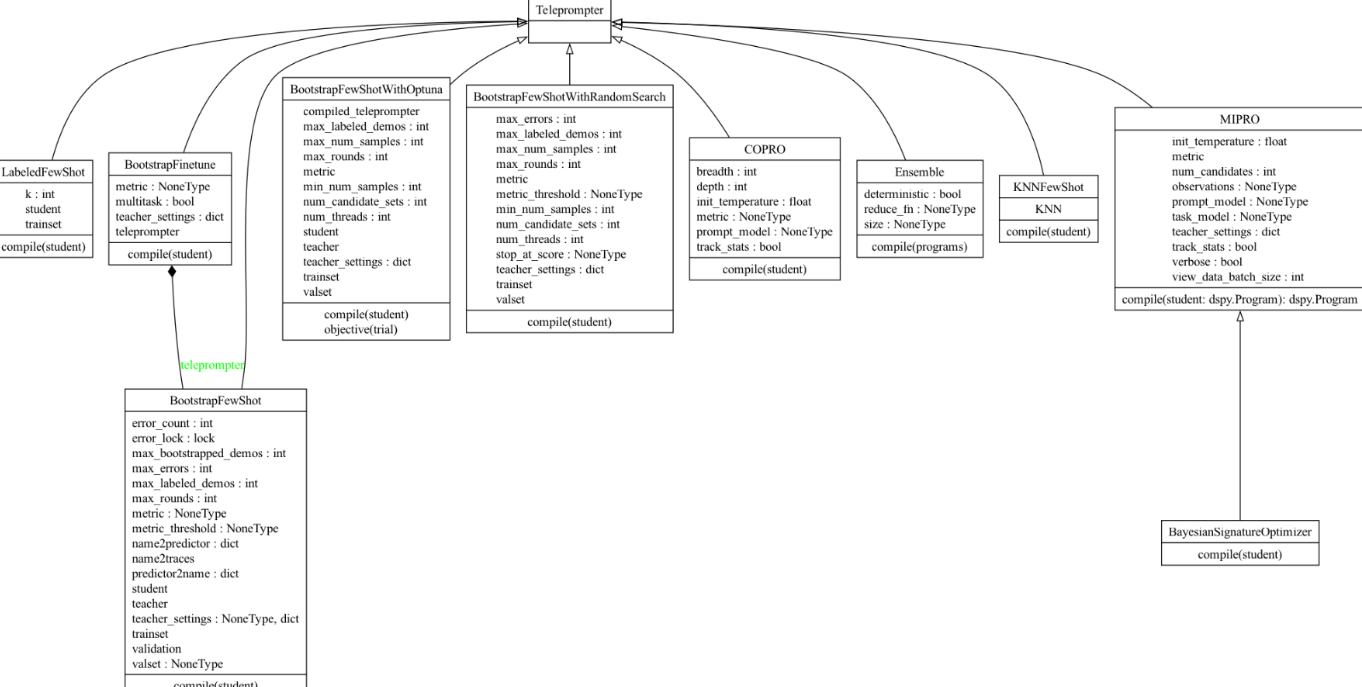


Let's get started with the `LabeledFewShot` optimizer.

The `LabeledFewShot` optimizer very simply provides a sample of the `trainset` as few-shot examples!

In [26]:
from dspy import LabeledFewShot

# 😉 LabeledFewShot is nothing but adding 'k' few shot prompts randomly picked from trainset.
# 😉 No reasoning about how to optimize the selection of few shots is involved.

labeled_fewshot_optimizer = LabeledFewShot(k=4)    

Once we define our optimizer, we can compile our program!

In [27]:
# 😉 Many optimizers including LabeledFewShot has a method 'compile' which takes in 'uncompiled' ('raw' or 'unoptimized' or 'with naive prompt') program
# 😉 and returns 'compiled' ('optimized' or 'with optimized prompt') pragram.


compiled_dspy = labeled_fewshot_optimizer.compile(student=DopeOrNopeStudent(), trainset=trainset)

In [28]:
# 🚀 My own cell

uncompiled_dspy = DopeOrNopeStudent()
uncompiled_dspy_response = uncompiled_dspy(sentence = valset_example.sentence)

compiled_dspy_response = compiled_dspy(sentence = valset_example.sentence)

# llm.inspect_history(n=2)

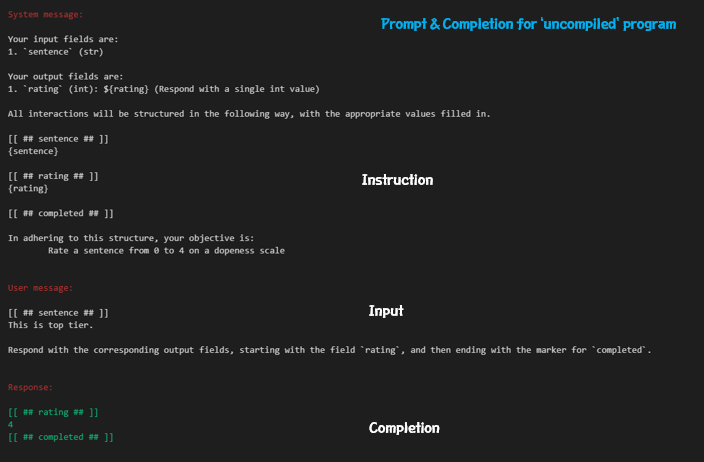

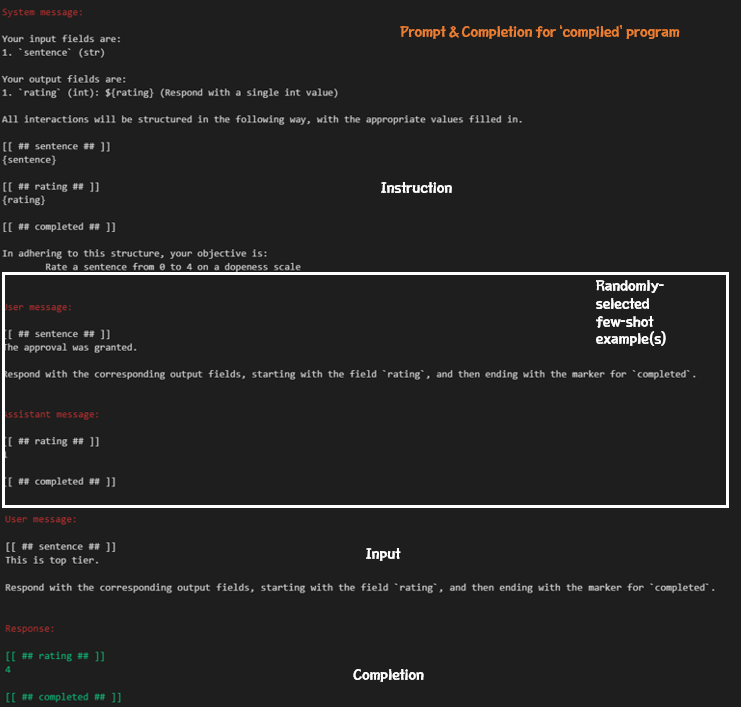

Let's evaluate!

In [29]:
# 😉 devset is fixed when it is creted. We can perform evaluation on the same devset with different programs

evaluate_fewshot(compiled_dspy, metric=exact_match_metric)

Average Metric: 4 / 10  (40.0): 100%|██████████| 10/10 [00:00<00:00, 307.07it/s]


,sentence,example_rating,pred_rating,exact_match_metric
0,This is top tier.,4,4,✔️ [True]
1,Big mood.,3,3,✔️ [True]
2,The presentation was outstanding.,1,3,
3,I'm living my best life.,4,3,
4,"Sksksksk, that's hilarious.",3,3,✔️ [True]
5,The report is comprehensive.,1,2,
6,This is next level.,4,3,
7,The meeting was productive.,1,3,
8,The analysis was insightful.,1,3,
9,I stan a legend.,3,3,✔️ [True]


40.0

As you can see - with no effort at all - we can improve our performance on our `valset`!

Let's try another optimizer - this time: [`BootstrapFewShot`](https://dspy-docs.vercel.app/docs/deep-dive/teleprompter/bootstrap-fewshot).

The key thing to note is that this optimizer works with even very few examples - by way of generating new examples by the LLMs!

In [32]:
from dspy import BootstrapFewShot


# 😉 Unlike LabeledFewShot, BootstrapFewShot involves optimization process which means it needs metric.
optimizer = BootstrapFewShot(metric=exact_match_metric, max_bootstrapped_demos=4, max_labeled_demos=12)

compiled_dspy_BOOTSTRAP = optimizer.compile(student=DopeOrNopeStudent(), trainset=trainset)

  6%|▌         | 5/89 [00:04<01:21,  1.03it/s]

Bootstrapped 4 full traces after 6 examples in round 0.


#### 🏗️ Activity #1:

Outline how `BootstrapFewShot` works "under the hood" in natural language or create a diagram of the workflow.

#### 🚀 Answer to Activity #1:

😉 1. **Constuctor**

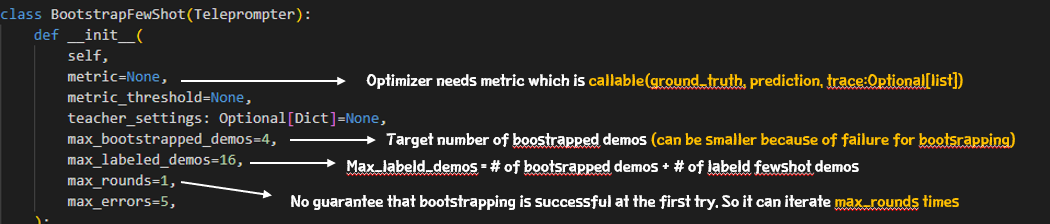

😉 2. **Flow of compiling (optimization)**

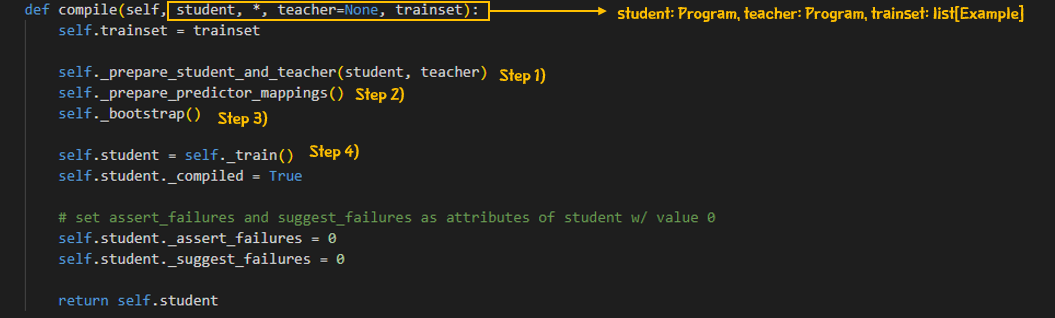

- Step 1) _prepare_student_and_teacher(self, student, teacher)

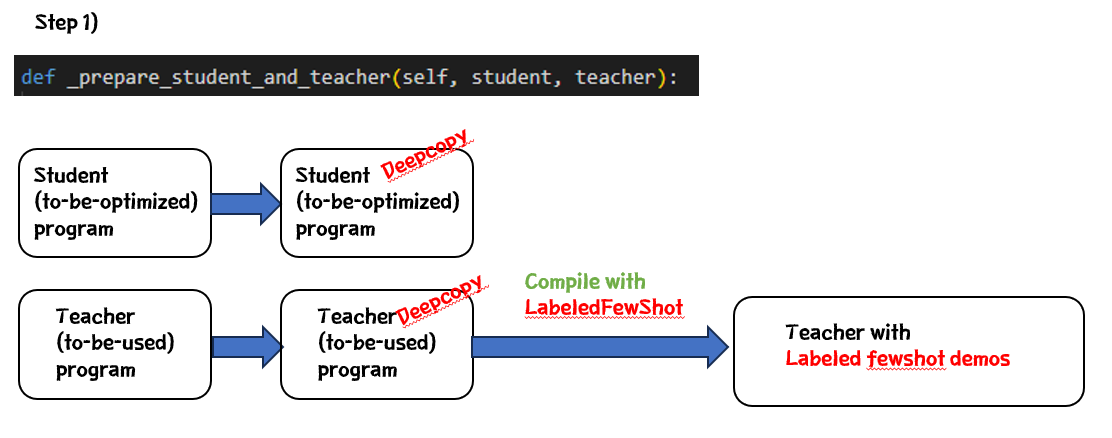

- Step 2) _prepare_predictor_mappings()

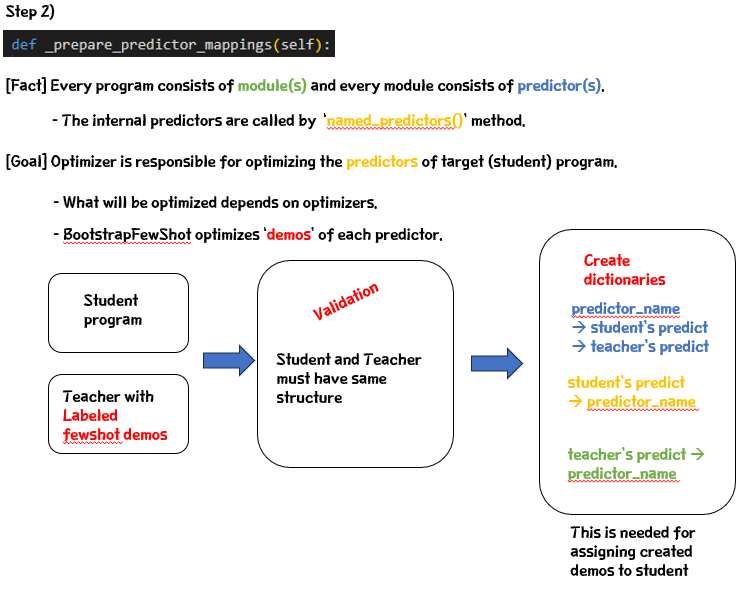

- Step 3)

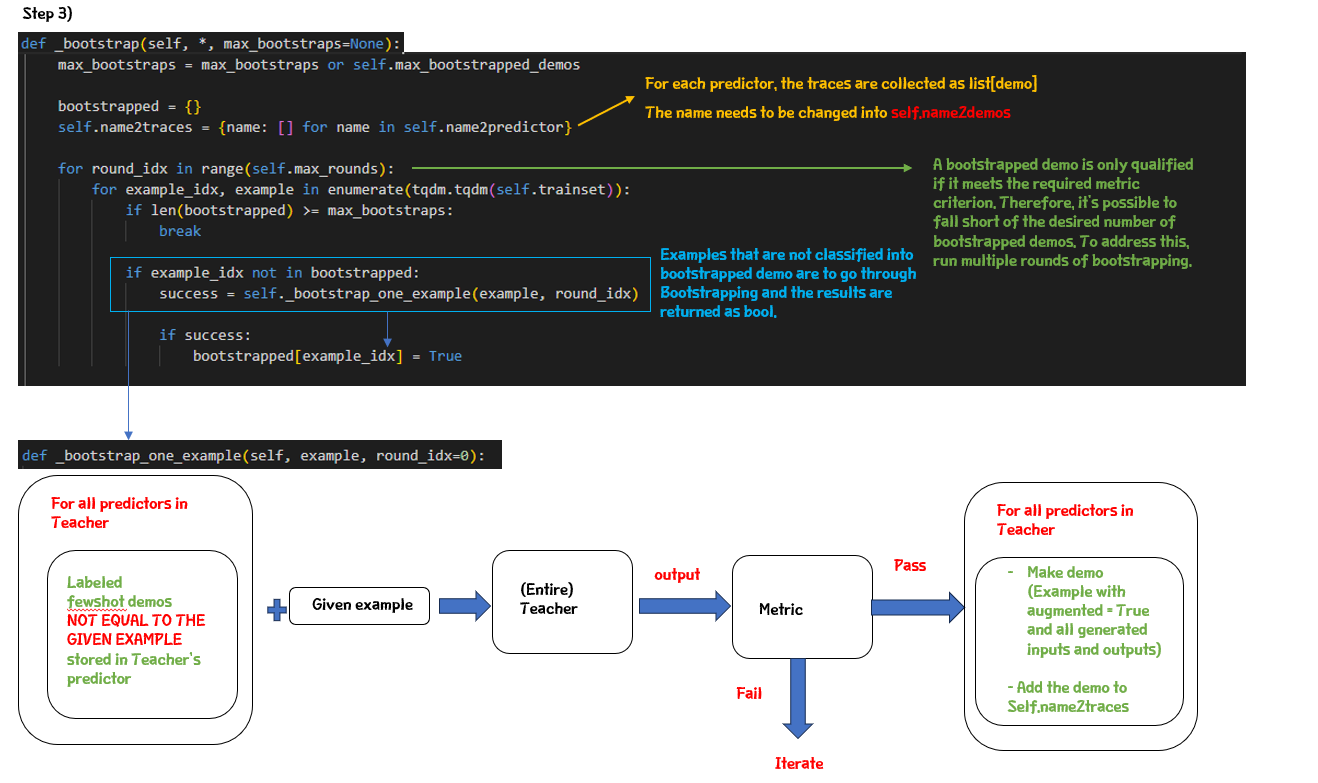

- Step 4)

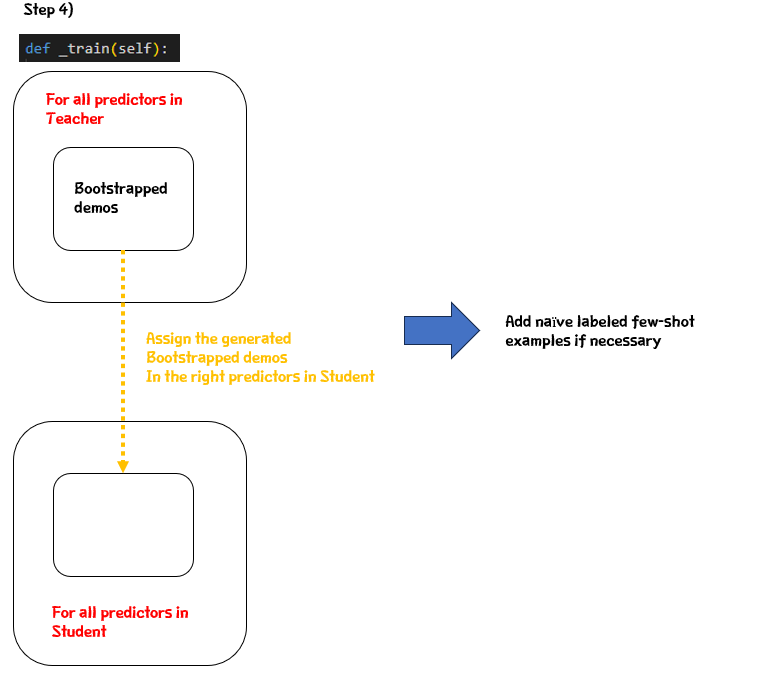

Let's finally evaluate!

In [33]:
evaluate_fewshot(compiled_dspy_BOOTSTRAP, metric=exact_match_metric)

  0%|          | 0/10 [00:00<?, ?it/s]

Average Metric: 8 / 10  (80.0): 100%|██████████| 10/10 [00:06<00:00,  1.62it/s]


,sentence,example_rating,pred_rating,exact_match_metric
0,This is top tier.,4,4,✔️ [True]
1,Big mood.,3,3,✔️ [True]
2,The presentation was outstanding.,1,3,
3,I'm living my best life.,4,4,✔️ [True]
4,"Sksksksk, that's hilarious.",3,3,✔️ [True]
5,The report is comprehensive.,1,1,✔️ [True]
6,This is next level.,4,4,✔️ [True]
7,The meeting was productive.,1,1,✔️ [True]
8,The analysis was insightful.,1,2,
9,I stan a legend.,3,3,✔️ [True]


80.0

We can see that this optimization helps our program achieve 30 points higher on our evaluation!

In [35]:
# llm.inspect_history(n=1)

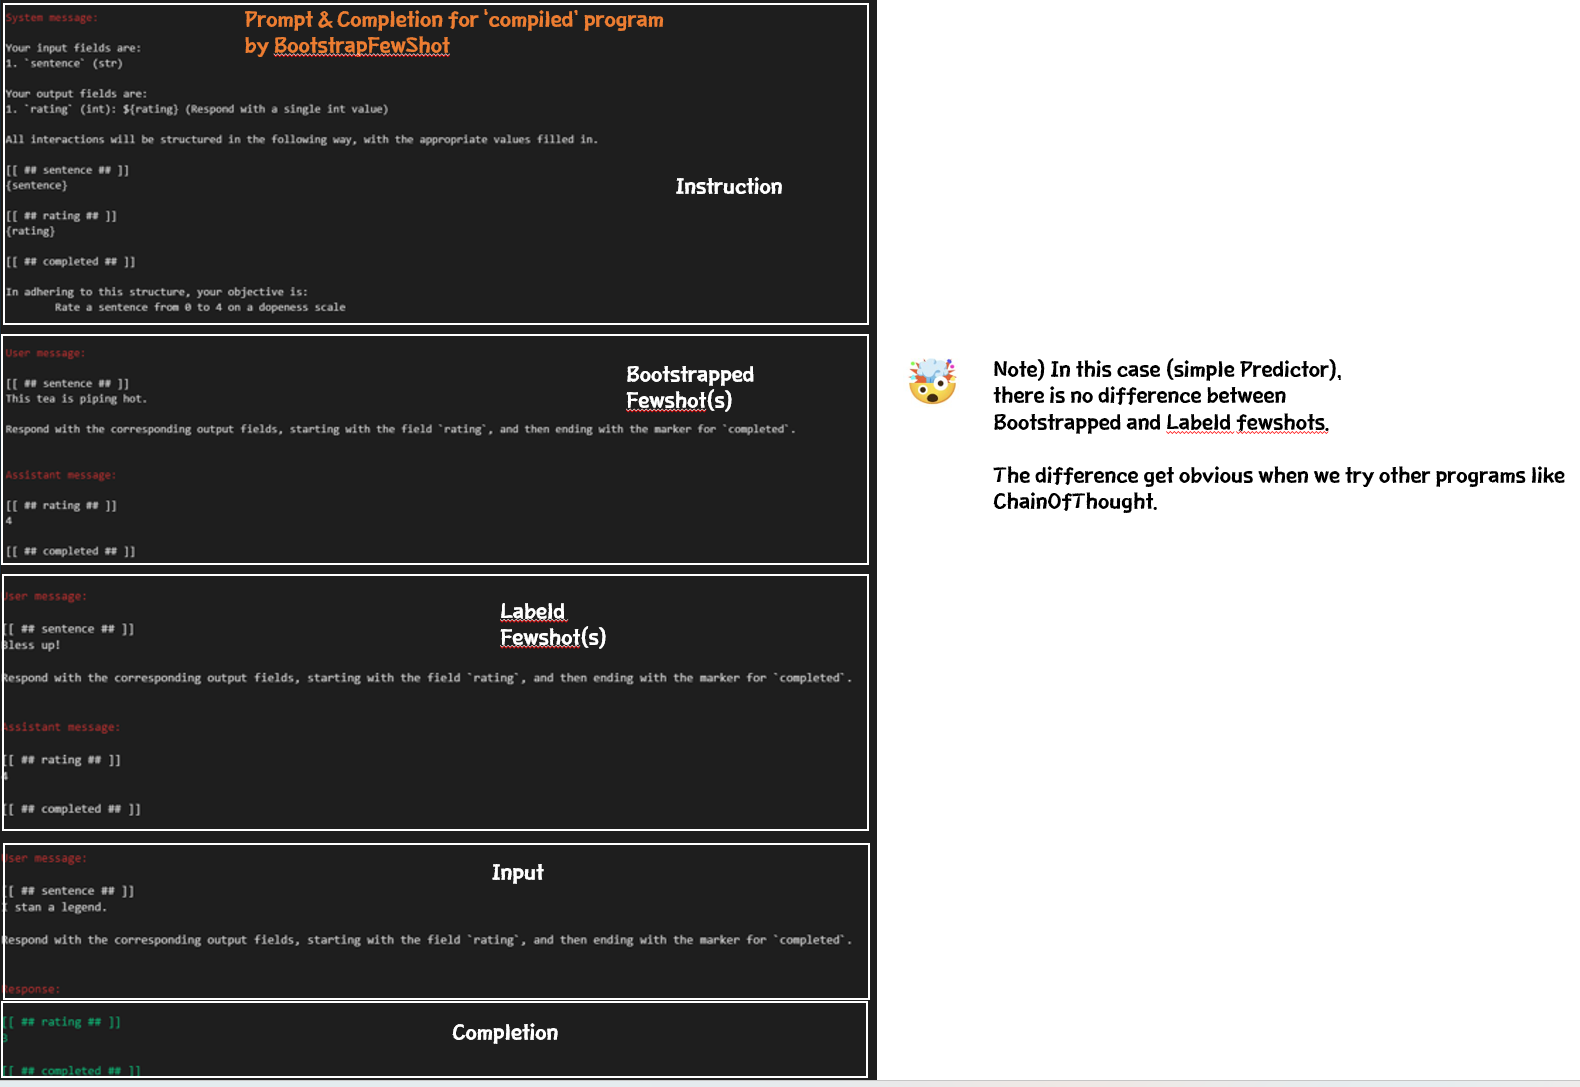

In [37]:
# 😉 Most 'module' has three parameters: 1) llm weights, 2) intruction part of prompt, 3) demo (few shot part of prompt)
# 😉 For a program, every module inside of the program is considered as a parameter 
# 😉 Basically, DSPy's optimizer is respnsible for optimizing all the nested parameters of parameters. 

for name, parameter in compiled_dspy_BOOTSTRAP.named_parameters():
  print(f"Parameter {name}: Num Examples: {len(parameter.demos)}, {parameter.demos[0]}")


Parameter generate_rating.predictor: Num Examples: 12, Example({'augmented': True, 'sentence': 'This tea is piping hot.', 'rating': 4}) (input_keys=None)


# 🤝 Breakout Room #2

## Task 1: Defining Application

In this breakoutroom, we'll be using DSPy to optimize a Multi-Hop QA module with `Assertions`.

So what is a "Multi-Hop QA module"?

Well - going beyond naive RAG retrieval, Multi-Hop QA lets us create applications that are well-suited to questions that (potentially have) multiple "hops" required to answer them.

For instance: "Who is the top goal scorer that has ever played on the Winnipeg Jets, and what years did he play for the Winnipeg Jets?"

You can see that there are two "hops" required to respond correctly:

1. Who is the top goal scorer for the Winnipeg Jets?
2. What years did X player play for the Winnipeg Jets?

While this is a toy example, the idea is the same across complexity: Questions that take more than one step of reasoning to answer.

Let's grab some data, set-up some hyper-parameters, and then get to implmentation!

## Task 2: Hyper-Parameters and Data

We'll use the DSPy ColBERT abstracts as our retrieval system for this example.

We'll also use `GPT-4o-Mini` as our LM to keep things light and inexpensive as we'll be sending quite a few LLM calls.

In [51]:
# 🚀 My own cell
# 😉 So far, we've invoke a bunch of llm calls. As a result, the global 'trace' gets to have many components
print(len(dspy.settings.config['trace']))
print(dspy.settings.config['trace'][0])
print('-'*50)
print(dspy.settings.config['trace'][0][0])
print(dspy.settings.config['trace'][0][1])
print(dspy.settings.config['trace'][0][2])

35
(Predict(DopeOrNopeSignature(sentence -> rating
    instructions='Rate a sentence from 0 to 4 on a dopeness scale'
    sentence = Field(annotation=str required=True json_schema_extra={'__dspy_field_type': 'input', 'prefix': 'Sentence:', 'desc': '${sentence}'})
    rating = Field(annotation=int required=True json_schema_extra={'__dspy_field_type': 'output', 'prefix': 'Rating:', 'desc': '${rating}'})
)), {'sentence': 'This is top tier.'}, Prediction(
    rating=4
))
--------------------------------------------------
Predict(DopeOrNopeSignature(sentence -> rating
    instructions='Rate a sentence from 0 to 4 on a dopeness scale'
    sentence = Field(annotation=str required=True json_schema_extra={'__dspy_field_type': 'input', 'prefix': 'Sentence:', 'desc': '${sentence}'})
    rating = Field(annotation=int required=True json_schema_extra={'__dspy_field_type': 'output', 'prefix': 'Rating:', 'desc': '${rating}'})
))
{'sentence': 'This is top tier.'}
Prediction(
    rating=4
)


In [121]:
colbertv2_wiki17_abstracts = dspy.ColBERTv2(url='http://20.102.90.50:2017/wiki17_abstracts')
dspy.settings.configure(rm=colbertv2_wiki17_abstracts)
lm_openai_four_mini = dspy.LM(model='openai/gpt-4o-mini', max_tokens=500)
lm_openai_four = dspy.LM(model='openai/gpt-4o', max_tokens=500)
dspy.settings.configure(lm=lm_openai_four_mini, trace=[], temperature=0.7)  # 😉 Empty trace
# dspy.settings.configure(lm=lm_openai_four, trace=[], temperature=0.7)  # 😉 Empty trace

Initialized chat model: openai/gpt-4o-mini
Initialized chat model: openai/gpt-4o


We'll be using the [`HotPotQA`](https://hotpotqa.github.io/) dataset which is a number of multi-hop QA pairs that includes context, and is based on Wikipedia (for compatibility with our Retriever system).

In [122]:
from dspy.datasets import HotPotQA

dataset = HotPotQA(train_seed=1, train_size=20, eval_seed=2023, dev_size=50, test_size=0, keep_details=True)
trainset = [x.with_inputs('question') for x in dataset.train] # 😉 Set 'question' as input, no outputs
devset = [x.with_inputs('question') for x in dataset.dev] # 😉 Set 'question' as input, no outputs

In [123]:
# 🚀 My own cell
print(trainset[0].inputs())
trainset[0].keys()

Example({'question': 'At My Window was released by which American singer-songwriter?'}) (input_keys={'question'})


['id', 'question', 'answer', 'type', 'context', 'gold_titles']

We can look at a few examples:

In [124]:
train_example = trainset[0]
print(f"Question: {train_example.question}")
print(f"Answer: {train_example.answer}")
print(f"Relevant Wikipedia Titles: {train_example.gold_titles}")

Question: At My Window was released by which American singer-songwriter?
Answer: John Townes Van Zandt
Relevant Wikipedia Titles: {'Townes Van Zandt', 'At My Window (album)'}


In [125]:
dev_example = devset[18]
print(f"Question: {dev_example.question}")
print(f"Answer: {dev_example.answer}")
print(f"Relevant Wikipedia Titles: {dev_example.gold_titles}")

Question: What is the nationality of the chef and restaurateur featured in Restaurant: Impossible?
Answer: English
Relevant Wikipedia Titles: {'Robert Irvine', 'Restaurant: Impossible'}


## Task 3: Signature and Module Creation

As we learned above - the bread and butter for DSPy is the `Signature` and `Module`, so we'll create each below.

For our `Signatures`, things are fairly straight-forward, we need to:

1. Create a `Signature` that will allow us to generate sub-questions.
2. Create a `Signature` that will provide citations for our responses.

In [175]:
from dsp.utils import deduplicate

# 😉 Add type hints
class GenerateSearchQuery(dspy.Signature):
    """Write a simple search query that will help answer a complex question."""
    context: str = dspy.InputField(desc="may contain relevant facts") 
    question: str = dspy.InputField()
    query: str = dspy.OutputField()

# 😉 Add type hints
# class GenerateCitedParagraph(dspy.Signature):
#     """Generate a paragraph with citations."""
#     context: str = dspy.InputField(desc="may contain relevant facts")
#     question: str = dspy.InputField()
#     paragraph: str = dspy.OutputField(desc="includes citations as only numbers [1], [2], .. right after the corresponding sentence.")

class GenerateCitedParagraph(dspy.Signature):
    """Generate a paragraph with citations."""
    context = dspy.InputField(desc="may contain relevant facts")
    question = dspy.InputField()
    paragraph = dspy.OutputField(desc="includes citations")

Our `Module` is a bit more complex than what we've seen before - so let's walk through what's happening inside of it. We're going to concern ourselves with the `forward` method - as that is where the logic of our `Module` is contained.

In the `forward` method we:

1. Create an empty list of contexts.
2. For each `hop` in our `max_hops` (by default, it will be 2) we:
  - Generate a new `query` using our `GenerateSearchQuery` with a `ChainOfThought` predictor.
  - Retrieve a number (default 3) of `passages` based on that new `query`.
  - Add unique (non-present) `passages` into our `context` list.
3. Take all that `context` and our original `question` and generate a cited paragraph and use it to predict an answer.

### 🚀 dspy.Retrieve

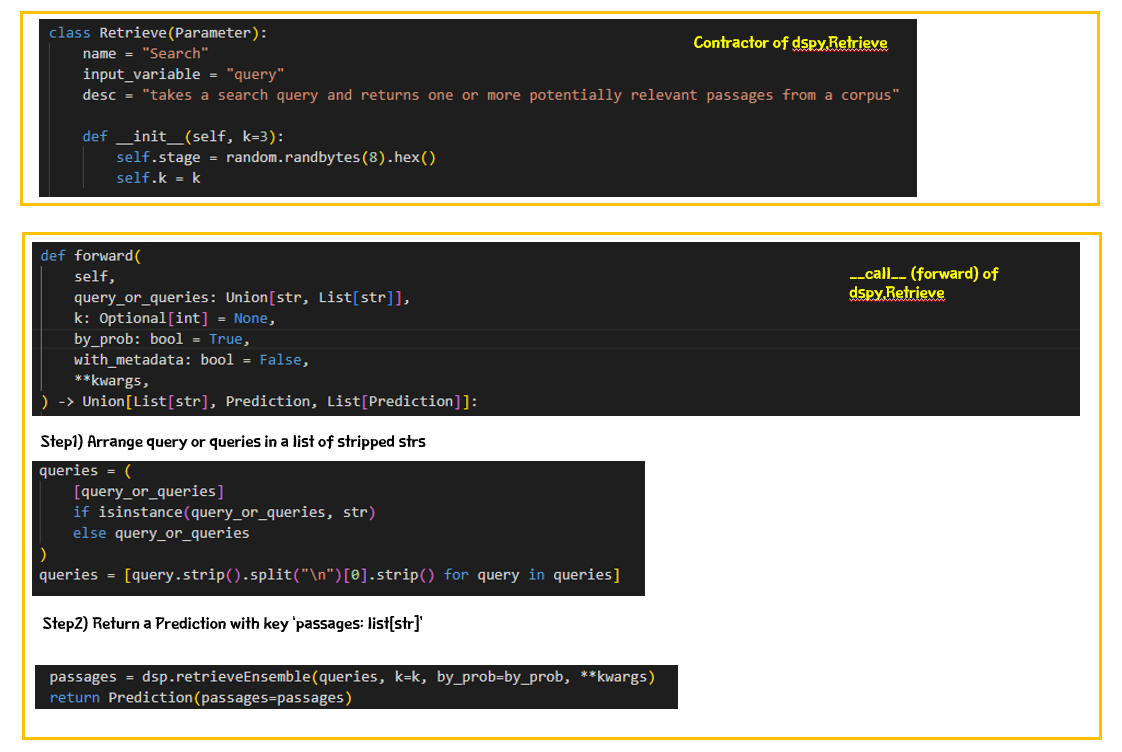

In [176]:
class LongFormQA(dspy.Module):
    def __init__(self, passages_per_hop=3, max_hops=2):
        super().__init__()

        self.generate_query = [dspy.ChainOfThought(GenerateSearchQuery) for _ in range(max_hops)]
        self.retrieve = dspy.Retrieve(k=passages_per_hop)
        self.generate_cited_paragraph = dspy.ChainOfThought(GenerateCitedParagraph)
        self.max_hops = max_hops

    # 😉 Add **kwargs
    def forward(self, question: str, **kwargs):
        context = []
        for hop in range(self.max_hops):
            query = self.generate_query[hop](context=context, question=question, **kwargs).query
            passages = self.retrieve(query).passages
            context = deduplicate(context + passages)
        pred = self.generate_cited_paragraph(context=context, question=question, **kwargs)
        
        pred = dspy.Prediction(context=context, paragraph=pred.paragraph)
        return pred

In [177]:
# 🚀 My own cell

program = LongFormQA()
program  # 😉 Displays all predictors

generate_query[0] = Predict(StringSignature(context, question -> reasoning, query
    instructions='Write a simple search query that will help answer a complex question.'
    context = Field(annotation=str required=True json_schema_extra={'desc': 'may contain relevant facts', '__dspy_field_type': 'input', 'prefix': 'Context:'})
    question = Field(annotation=str required=True json_schema_extra={'__dspy_field_type': 'input', 'prefix': 'Question:', 'desc': '${question}'})
    reasoning = Field(annotation=str required=True json_schema_extra={'prefix': "Reasoning: Let's think step by step in order to", 'desc': '${reasoning}', '__dspy_field_type': 'output'})
    query = Field(annotation=str required=True json_schema_extra={'__dspy_field_type': 'output', 'prefix': 'Query:', 'desc': '${query}'})
))
generate_query[1] = Predict(StringSignature(context, question -> reasoning, query
    instructions='Write a simple search query that will help answer a complex question.'
    context = Field(annot

Next, we'll need a way to evaluate how we're doing!

## Task 4: Evaluating our LongFormQA Module.

Now we'd like to evaluate our module - we'll need a number of helper functions to do so - which will be instantiated below.

#### Utility Functions for Citation Checking

In [178]:
import nltk
import regex as re

from nltk.tokenize import sent_tokenize
nltk.download('punkt')

# 😉 Look at the paragraph (final output of program) and return a dictionary wihch breaks down the paragraph according to citation
def extract_text_by_citation(paragraph):
    citation_regex = re.compile(r'(.*?)(\[\d+\]\.)', re.DOTALL)
    parts_with_citation = citation_regex.findall(paragraph)

    citation_dict = {}
    for part, citation in parts_with_citation:
        part = part.strip()
        citation_num = re.search(r'\[(\d+)\]\.', citation).group(1)
        citation_dict.setdefault(str(int(citation_num) - 1), []).append(part)
    return citation_dict

# 😉 Check if the paragraph has the correct citation format
def correct_citation_format(paragraph):
    modified_sentences = []
    sentences = sent_tokenize(paragraph)
    for sentence in sentences:
        modified_sentences.append(sentence)
    citation_regex = re.compile(r'\[\d+\]\.')
    i = 0
    if len(modified_sentences) == 1:
      has_citation = bool(citation_regex.search(modified_sentences[i]))
    while i < len(modified_sentences):
      if len(modified_sentences[i:i+2]) == 2:
        sentence_group = " ".join(modified_sentences[i:i+2])
        has_citation = bool(citation_regex.search(sentence_group))
        if not has_citation:
            return False
        i += 2 if has_citation and i+1 < len(modified_sentences) and citation_regex.search(modified_sentences[i+1]) else 1
      else:
        return True
    return True

# 😉 Check if the paragraph mentions citations
def has_citations(paragraph):
    return bool(re.search(r'\[\d+\]\.', paragraph))

# 😉 Check if the paragraph mentions citations in the correct format
def citations_check(paragraph):
    return has_citations(paragraph) and correct_citation_format(paragraph)

[nltk_data] Downloading package punkt to /home/jetlee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [179]:
# 🚀 My own cell

devset_example = devset[1]
response = program(**devset_example.inputs())
context = response.context
paragraph = response.paragraph

citation_dict = extract_text_by_citation(paragraph)
is_correct_citation = correct_citation_format(paragraph)
_has_citations = has_citations(paragraph)
_citations_check = citations_check(paragraph)


print(f"Question: {devset_example.question}")
print(f"context: {context}")
print(f"paragraph : {paragraph }")
print(f"citation_dict: {citation_dict}")
print(f"is_correct_citation: {is_correct_citation}")
print(f"has_citations: {_has_citations}")
print(f"citations_check: {_citations_check}")


Question: Who conducts the draft in which Marc-Andre Fleury was drafted to the Vegas Golden Knights for the 2017-18 season?
context: ["2017 NHL Expansion Draft | The 2017 NHL Expansion Draft was an expansion draft conducted by the National Hockey League on June 18–20, 2017 to fill the roster of the league's expansion team for the 2017–18 season, the Vegas Golden Knights. The team's selections were announced on June 21 during the NHL Awards ceremony at T-Mobile Arena.", '2017 NHL Entry Draft | The 2017 NHL Entry Draft was the 55th NHL Entry Draft. The draft was held from June 23–24, 2017, at the United Center in Chicago, Illinois. The first three selections were Nico Hischier, Nolan Patrick and Miro Heiskanen.', '2017–18 NHL season | The 2017–18 NHL season is the 101st season of operation (100th season of play) of the National Hockey League. With the addition of a new expansion team, the Vegas Golden Knights, 31 teams compete in an 82-game regular season. The regular season will begin o

### Checking Citation Faithfulness

We will create a number of useful metrics for our pipeline - included "Faithfulness", as well as a number of more traditional metrics. "

In [252]:
# 😉 'Faithfullness' is something we can figure out with the help of llm (promgram) so let's define Singnature first.
class CheckCitationFaithfulness(dspy.Signature):
    """Verify that the text is based on the provided context."""
    context = dspy.InputField(desc="may contain relevant facts")
    text = dspy.InputField(desc="between 1 to 2 sentences")
    faithfulness = dspy.OutputField(desc="boolean indicating if text is faithful to context")


# 😉 This is a custom metric in accordance with DSPy's metric requirement (ground_truth, prediction, trace)
# 😉 In fact ground_truth (exmple) and trace are not used. But it tries to follow the function signature requirement from DSPy.
def citation_faithfulness(example, pred, trace):
    paragraph, context = pred.paragraph, pred.context     #  pred is a Prediction object with 'paragraph: str' and 'context: list[str]'

    citation_dict = extract_text_by_citation(paragraph)   # break down the paragraph according to citation 
    
    if not citation_dict:
        return False, None   # If no citations is extracted, returns (False, None)
    
    context_dict = {str(i): context[i].split(' | ')[1] for i in range(len(context))}   # Get context dictionary according to citation number
    faithfulness_results: list[bool] = []  # List of faithfulness results to aggregate score  
    unfaithful_citations: list[dict] = []  # List of dictinalries which describe failure cases
    
    check_citation_faithfulness = dspy.ChainOfThought(CheckCitationFaithfulness) # Define a ChainOfThought off-the-shelf module to get 'faithfulness'
    
    for citation_num, texts in citation_dict.items():
        if citation_num not in context_dict:  # This is an Exception case. Ignore it.
            continue

        current_context = context_dict[citation_num]   # Get the context asscoiated with the citation number
        
        for text in texts:
            try:
                result = check_citation_faithfulness(context=current_context, text=text)  # By using CoT module, get the 'faithfulness' result
                is_faithful = result.faithfulness.lower() == 'true'
                faithfulness_results.append(is_faithful)
                if not is_faithful:
                    unfaithful_citations.append({'paragraph': paragraph, 'text': text, 'context': current_context})
            except ValueError as e:
                faithfulness_results.append(False)
                unfaithful_citations.append({'paragraph': paragraph, 'text': text, 'error': str(e)})
    
    final_faithfulness = all(faithfulness_results) # Judge as pass only if all citations are faithful
    
    if not faithfulness_results:  # Unexped Exception case
        return False, None
    
    return final_faithfulness, unfaithful_citations   # (True, [Unfatihtful cases])

#### ❓Question #2:

How is faithfulness being determined here? How is this different from Ragas Faithfulness.

### 🚀 Answer to Question #2

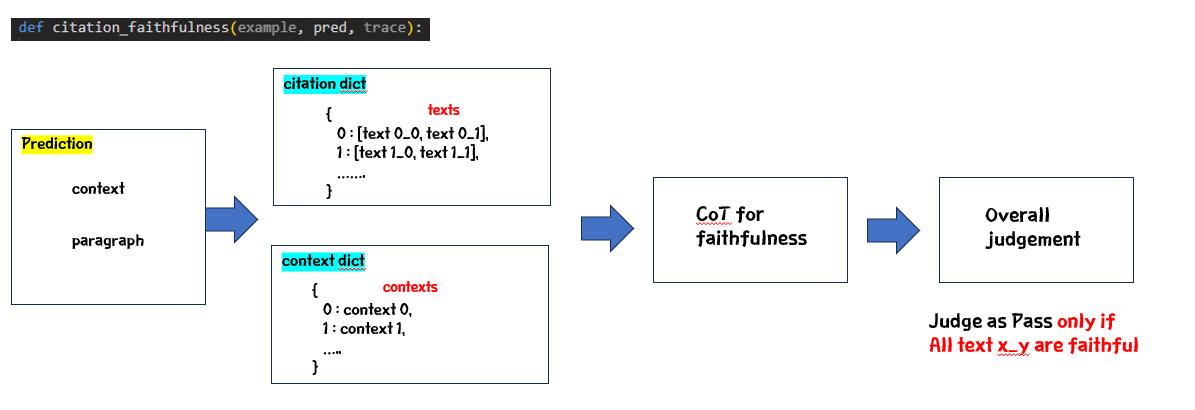


How different from Ragas?

- (similarity) Both Ragas and our version leverage an llm to measure actual consistency of the generated answer against the given context.

- (similarity) Both Ragas and our version carefully look at every claim in the generated anser.

- (difference) While our version returns faithfulness as boolean value (True / False), Ragas returns as a float point value between 0 and 1.

- (difference) The system message of Ragas faithfulness checker is much complex.

Next, we can create a number of useful metrics that rely on more traditional evaluations, like Precision, Recall, and "does this contain the answer".

In [181]:
from dsp.utils import normalize_text

def extract_cited_titles_from_paragraph(paragraph, context):
    cited_indices = [int(m.group(1)) for m in re.finditer(r'\[(\d+)\]\.', paragraph)]
    cited_indices = [index - 1 for index in cited_indices if index <= len(context)]
    cited_titles = [context[index].split(' | ')[0] for index in cited_indices]
    return cited_titles

def calculate_recall(example, pred, trace=None):
    gold_titles = set(example['gold_titles'])
    found_cited_titles = set(extract_cited_titles_from_paragraph(pred.paragraph, pred.context))
    intersection = gold_titles.intersection(found_cited_titles)
    recall = len(intersection) / len(gold_titles) if gold_titles else 0
    return recall

def calculate_precision(example, pred, trace=None):
    gold_titles = set(example['gold_titles'])
    found_cited_titles = set(extract_cited_titles_from_paragraph(pred.paragraph, pred.context))
    intersection = gold_titles.intersection(found_cited_titles)
    precision = len(intersection) / len(found_cited_titles) if found_cited_titles else 0
    return precision

def answer_correctness(example, pred, trace=None):
    assert hasattr(example, 'answer'), "Example does not have 'answer'."
    normalized_context = normalize_text(pred.paragraph)
    if isinstance(example.answer, str):
        gold_answers = [example.answer]
    elif isinstance(example.answer, list):
        gold_answers = example.answer
    else:
        raise ValueError("'example.answer' is not string or list.")
    return 1 if any(normalize_text(answer) in normalized_context for answer in gold_answers) else 0

### Creating the Evaluation Function

In essence, all this function does is call all the created metrics above and sum/average them.

In [182]:
from tqdm import tqdm

def evaluate(module):  # module is a program
    correctness_values = []
    recall_values = []
    precision_values = []
    citation_faithfulness_values = []
    for i in tqdm(range(len(devset[:20]))):
        example = devset[i]
        try:
            pred = module(question=example.question)
            correctness_values.append(answer_correctness(example, pred))
            citation_faithfulness_score, _ = citation_faithfulness(None, pred, None)
            citation_faithfulness_values.append(citation_faithfulness_score)
            recall = calculate_recall(example, pred)
            precision = calculate_precision(example, pred)
            recall_values.append(recall)
            precision_values.append(precision)
        except Exception as e:
            print(f"Failed generation with error: {e}")

    average_correctness = sum(correctness_values) / len(devset[:20]) if correctness_values else 0
    average_recall = sum(recall_values) / len(devset[:20]) if recall_values else 0
    average_precision = sum(precision_values) / len(devset[:20]) if precision_values else 0
    average_citation_faithfulness = sum(citation_faithfulness_values) / len(devset[:20]) if citation_faithfulness_values else 0

    print(f"\nAverage Correctness: {average_correctness}")
    print(f"Average Recall: {average_recall}")
    print(f"Average Precision: {average_precision}")
    print(f"Average Citation Faithfulness: {average_citation_faithfulness}")

### Evaluating our LongFormQA Module

Finally, we can evaluate our module!

In [183]:
longformqa = LongFormQA()
evaluate(longformqa)

100%|██████████| 20/20 [00:24<00:00,  1.22s/it]


Average Correctness: 0.75
Average Recall: 0.025
Average Precision: 0.05
Average Citation Faithfulness: 0.0


In [186]:
# 🚀 My own cell
citation_checks = []
for i in tqdm(range(len(devset[:20]))):
    example = devset[i]
    try:
        pred = longformqa(question=example.question)
        paragraph = pred.paragraph
        citation_checks.append(citations_check(paragraph)) 
    except Exception as e:
        citation_checks.append(False)

print(citation_checks)
print(sum(citation_checks) / len(citation_checks))

100%|██████████| 20/20 [00:00<00:00, 2172.65it/s]

[False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False]
0.05


This did surprisingly poorly on `Recall`, `Precision` and `Citation Faithfulness`.

❓Question #3:

Why did our `Module` do surprisingly poorly on `Recall`, `Precision` and `Citation Faithfulness`?

> HINT: The name `LongFormQA` should provide a fairly big hint.

### 🚀 Answer to Question #3

- From the analysis above, I’ve identified that the primary reason for poor performance is that the LongFormQA program failed to reference citations in most cases (it failed 19 out of 20 times).
- This seems to be due to ths signature with lack of explanation about output formats (how to offer citations in the output).

## Task 5: Adding `Assertions`.

DSPy comes equipped with an extremely useful feature called `Assertions` and `Suggestions`.

Let's take a look at what each one does:

1. `dspy.Assert` - this is a hard rule that must be followed, and if it's not followed; an exception will be raised.
2. `dspy.Suggest` - this is a looser rule, or guiding principle, it will not raise an exception if the rule isn't met; but it will try and ensure the suggestion is met.

Let's improve our `Module` with some `dspy.Suggest`s!


### 🚀 DSPy Assertions

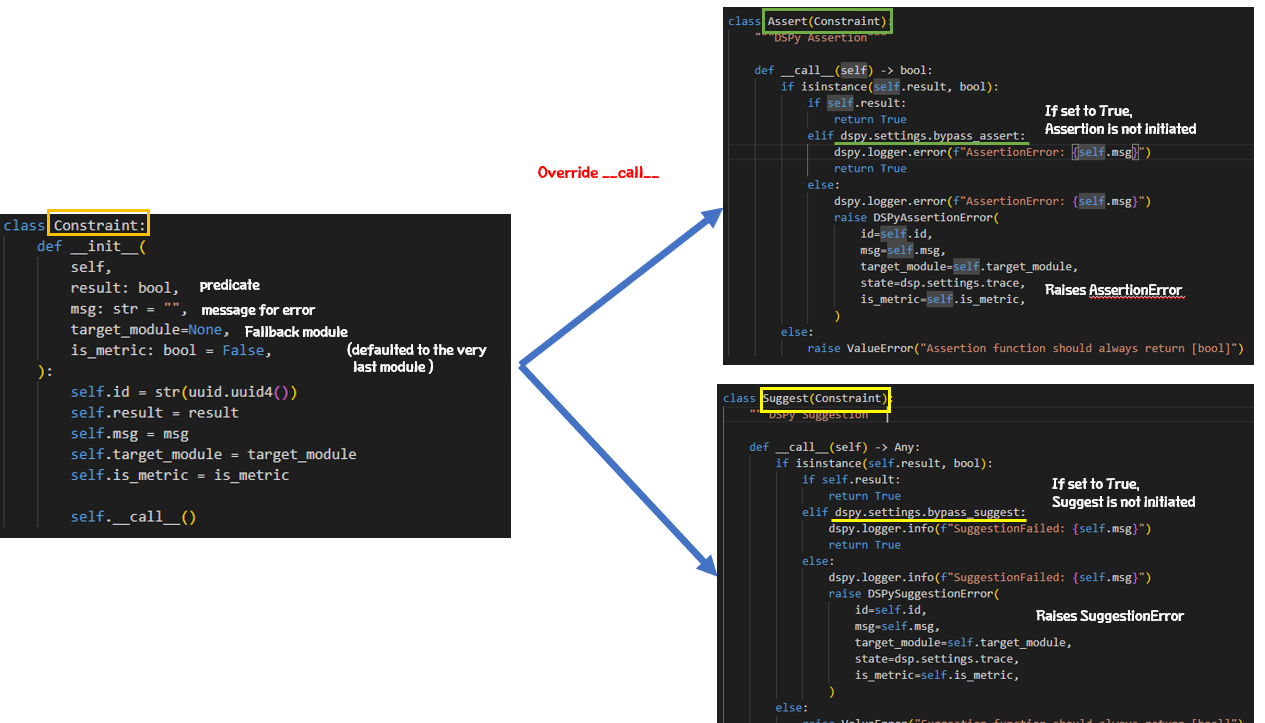

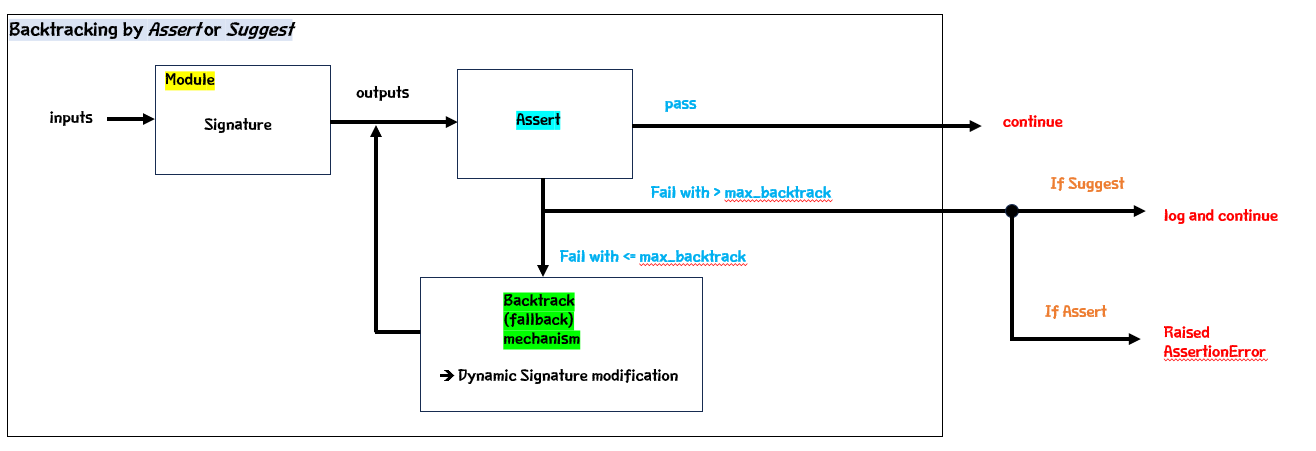

In [239]:
class LongFormQAWithAssertions(dspy.Module):
    def __init__(self, passages_per_hop=3, max_hops=2):
        super().__init__()
        self.generate_query = [dspy.ChainOfThought(GenerateSearchQuery) for _ in range(max_hops)]
        self.retrieve = dspy.Retrieve(k=passages_per_hop)
        self.generate_cited_paragraph = dspy.ChainOfThought(GenerateCitedParagraph)
        self.max_hops = max_hops

    def forward(self, question):
        context = []
        for hop in range(self.max_hops):
            query = self.generate_query[hop](context=context, question=question).query
            passages = self.retrieve(query).passages
            context = deduplicate(context + passages)
        
        pred = self.generate_cited_paragraph(context=context, question=question)  # 😉 Get prediction         
        pred = dspy.Prediction(context=context, paragraph=pred.paragraph)
        

        dspy.Suggest(
            result = citations_check(pred.paragraph), 
            msg = "Make sure every 1-2 sentences has citations. If any 1-2 sentences lack citations, add them in 'text... [x].' format.", 
            target_module = self.generate_cited_paragraph
            )  # 😉 Do validation (If the paragraph contains citation in the correct form?) and retry if necessary
        

        # 😉 Since we apply dspy.Suggest other than dspy.Assert, we get to this line regardless of success of failure        
        _, unfaithful_outputs = citation_faithfulness(None, pred, None) # 😉 len(unfaithful_outputs)>0 only if there was an formatting error for citation 
        

        if unfaithful_outputs:  # 😉 In case there were some 'unfaithfulness' without formatting error 
            unfaithful_pairs = [(output['text'], output['context']) for output in unfaithful_outputs]
            for _, context in unfaithful_pairs:
                dspy.Suggest(len(unfaithful_pairs) == 0, f"Make sure your output is based on the following context: '{context}'.", target_module=self.generate_cited_paragraph)
                # 😉 Retry 2 times
        
        else:
            return pred
        
        return pred

In [240]:
# 🚀 My own cell
from dspy.primitives.assertions import assert_transform_module, backtrack_handler
from dspy.predict import Retry

program_with_backtracking = assert_transform_module(LongFormQAWithAssertions(), backtrack_handler) 
example = devset[1]
pred = program_with_backtracking(question=example.question)


print(citations_check(pred.paragraph))

True


#### 🏗️ Activity #2:

Write out the above flow in natural language or using a drawing program.

What is the key advantage provided by using `dspy.Suggest`?

#### 🚀 Answer to Activity #2

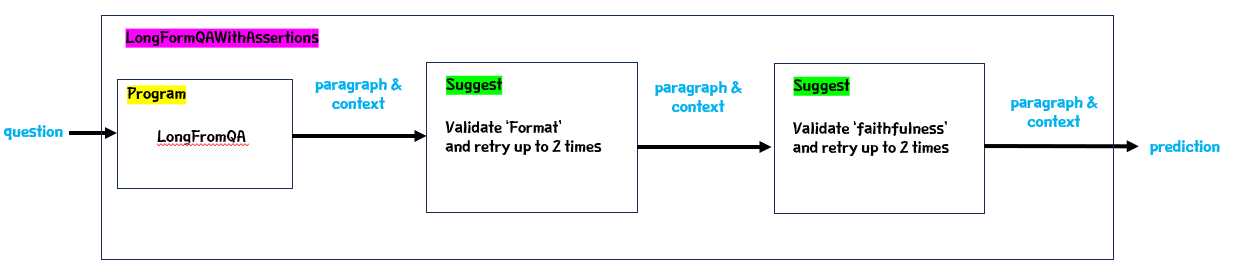

Q) What is the key advantage provided by using `dspy.Suggest`?

A)  dspy.Suggest functions like a 'Quality Assurance Department' for our program. It proactively inspects the responses of internal predictors and attempts to correct them based on the given criteria. Unlike dspy.Assert, which might halt the process if it encounters issues, dspy.Suggest allows the program to continue even if it can't fully resolve the failures, making it more suitable for the production phase.

In [241]:
from dspy.primitives.assertions import assert_transform_module, backtrack_handler
from dspy.predict import Retry

longformqa_with_assertions = assert_transform_module(LongFormQAWithAssertions().map_named_predictors(Retry), backtrack_handler)
evaluate(longformqa_with_assertions)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [03:05<00:00,  9.29s/it]


Average Correctness: 0.75
Average Recall: 0.425
Average Precision: 0.5
Average Citation Faithfulness: 0.25


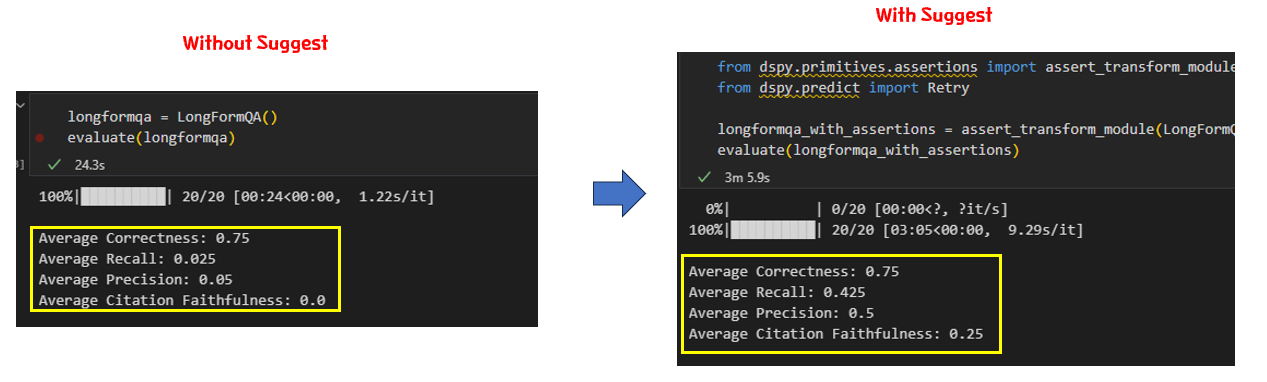

In [242]:
from dspy.teleprompt import BootstrapFewShotWithRandomSearch

longformqa = LongFormQAWithAssertions()
teleprompter = BootstrapFewShotWithRandomSearch(metric = answer_correctness, max_bootstrapped_demos=2, num_candidate_programs=6)
cited_longformqa_student_teacher = teleprompter.compile(student=assert_transform_module(LongFormQAWithAssertions().map_named_predictors(Retry), backtrack_handler), teacher = assert_transform_module(LongFormQAWithAssertions().map_named_predictors(Retry), backtrack_handler), trainset=trainset, valset=devset[:25])
evaluate(cited_longformqa_student_teacher)

Going to sample between 1 and 2 traces per predictor.
Will attempt to bootstrap 6 candidate sets.


Average Metric: 19 / 25  (76.0): 100%|██████████| 25/25 [01:31<00:00,  3.67s/it] 


New best score: 76.0 for seed -3
Scores so far: [76.0]
Best score so far: 76.0


Average Metric: 19 / 25  (76.0): 100%|██████████| 25/25 [00:00<00:00, 189.39it/s]


Scores so far: [76.0, 76.0]
Best score so far: 76.0


 20%|██        | 4/20 [00:59<03:56, 14.79s/it]


Bootstrapped 2 full traces after 5 examples in round 0.


Average Metric: 20 / 25  (80.0): 100%|██████████| 25/25 [05:35<00:00, 13.43s/it]


New best score: 80.0 for seed -1
Scores so far: [76.0, 76.0, 80.0]
Best score so far: 80.0


 10%|█         | 2/20 [00:33<05:03, 16.87s/it]


Bootstrapped 2 full traces after 3 examples in round 0.


Average Metric: 18 / 25  (72.0): 100%|██████████| 25/25 [06:09<00:00, 14.80s/it]


Scores so far: [76.0, 76.0, 80.0, 72.0]
Best score so far: 80.0


  5%|▌         | 1/20 [00:18<06:00, 19.00s/it]


Bootstrapped 1 full traces after 2 examples in round 0.


Average Metric: 19 / 25  (76.0): 100%|██████████| 25/25 [06:21<00:00, 15.28s/it]


Scores so far: [76.0, 76.0, 80.0, 72.0, 76.0]
Best score so far: 80.0


  5%|▌         | 1/20 [00:18<05:57, 18.81s/it]


Bootstrapped 1 full traces after 2 examples in round 0.


Average Metric: 19 / 25  (76.0): 100%|██████████| 25/25 [07:15<00:00, 17.42s/it]


Scores so far: [76.0, 76.0, 80.0, 72.0, 76.0, 76.0]
Best score so far: 80.0


 10%|█         | 2/20 [00:15<02:18,  7.71s/it]


Bootstrapped 1 full traces after 3 examples in round 0.


Average Metric: 21 / 25  (84.0): 100%|██████████| 25/25 [06:12<00:00, 14.92s/it]


New best score: 84.0 for seed 3
Scores so far: [76.0, 76.0, 80.0, 72.0, 76.0, 76.0, 84.0]
Best score so far: 84.0


  5%|▌         | 1/20 [00:17<05:25, 17.11s/it]


Bootstrapped 1 full traces after 2 examples in round 0.


Average Metric: 20 / 25  (80.0): 100%|██████████| 25/25 [05:53<00:00, 14.15s/it]


Scores so far: [76.0, 76.0, 80.0, 72.0, 76.0, 76.0, 84.0, 80.0]
Best score so far: 84.0


 15%|█▌        | 3/20 [00:55<05:14, 18.51s/it]


Bootstrapped 2 full traces after 4 examples in round 0.


Average Metric: 20 / 25  (80.0): 100%|██████████| 25/25 [07:07<00:00, 17.12s/it]


Scores so far: [76.0, 76.0, 80.0, 72.0, 76.0, 76.0, 84.0, 80.0, 80.0]
Best score so far: 84.0
9 candidate programs found.


100%|██████████| 20/20 [00:00<00:00, 300.34it/s]


Average Correctness: 0.85
Average Recall: 0.025
Average Precision: 0.05
Average Citation Faithfulness: 0.05


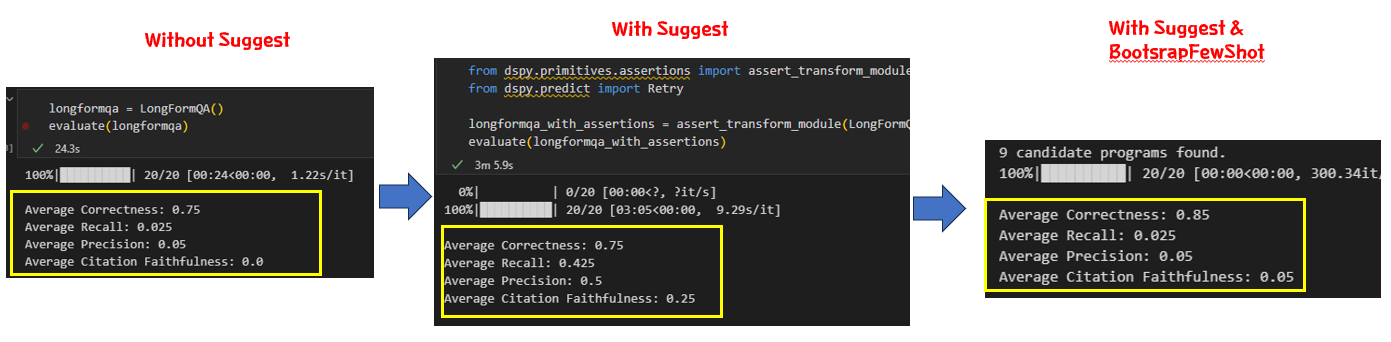